<a href="https://colab.research.google.com/github/sameeksha111/project/blob/main/Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Applying SMOTE to resample the training data...

--- Training Models and Calculating Metrics ---
Training Logistic Regression...
Training Random Forest...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Training Neural Network...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:59:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5211
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

--- Final Model Comparison Summary ---
| Model               |   AUC-ROC |   Precision@10% |
|:--------------------|----------:|----------------:|
| LightGBM            |    0.8445 |          0.7571 |
| XGBoost             |    0.8430 |          0.7429 |
| Logistic Regression |    0.8401 |          0.7429 |
| Random Forest       |    0.8146 |          0.6786 |
| Neural Network      |    0.7729 |          0.5643 |


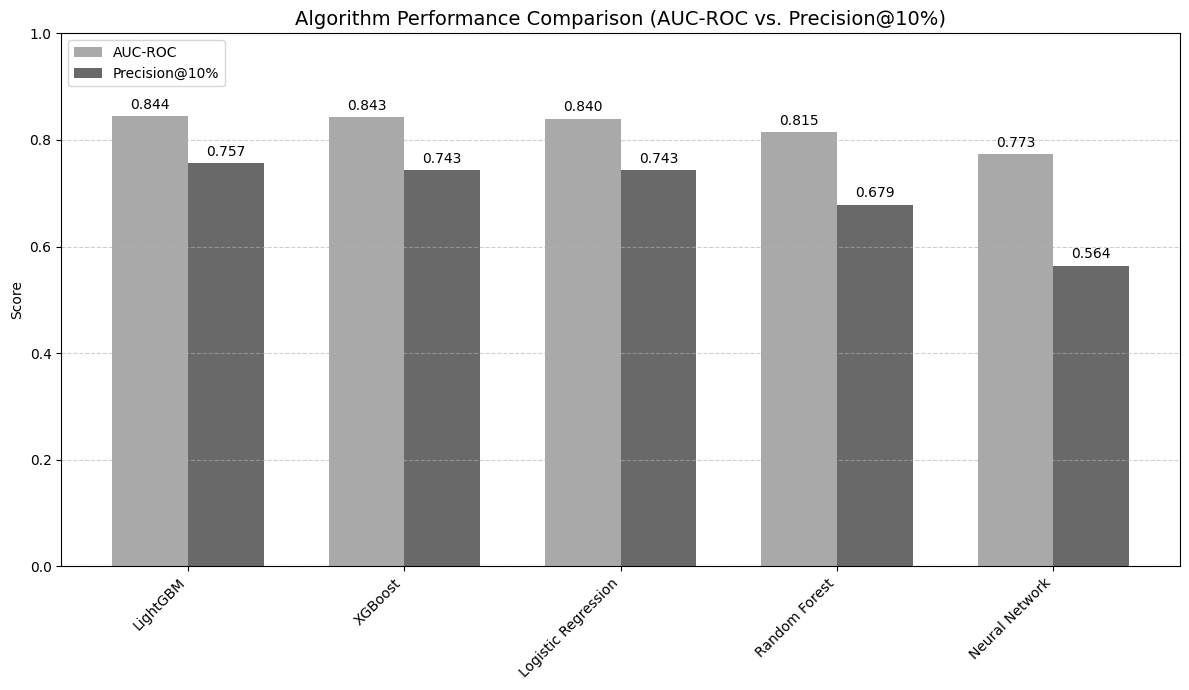

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc

# Configuration
DATA_URL = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
RANDOM_STATE = 42
TARGET_CHURN_PERCENT = 0.10

# 1. DATA LOADING AND PREPROCESSING
try:
    df = pd.read_csv(DATA_URL)
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

df.drop('customerID', axis=1, inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.fillna(df['TotalCharges'].median(), inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

X = df.drop('Churn', axis=1)
y = df['Churn']

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

X_train_processed = preprocessor.fit_transform(X_train)

print("Applying SMOTE to resample the training data...")
smote_sampler = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote_sampler.fit_resample(X_train_processed, y_train)

X_test_processed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

# 3. MODEL TRAINING
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=RANDOM_STATE, solver='liblinear'),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100),
    "Neural Network": MLPClassifier(random_state=RANDOM_STATE, max_iter=500, hidden_layer_sizes=(50, 20)),

    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=RANDOM_STATE,
        n_estimators=400,
        max_depth=4,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8
    ),

    "LightGBM": LGBMClassifier(
        random_state=RANDOM_STATE,
        n_estimators=500,
        learning_rate=0.01,
        num_leaves=15,
        min_child_samples=30
    )
}

results = []

def calculate_precision_at_k(y_true, y_pred_proba, k_percent):
    """Calculates precision at the top k percent of predictions."""
    N = len(y_true)
    k_val = int(N * k_percent)
    df_metrics = pd.DataFrame({'proba': y_pred_proba, 'true': y_true})
    df_sorted = df_metrics.sort_values(by='proba', ascending=False)
    precision = df_sorted.head(k_val)['true'].sum() / k_val
    return precision

print("\n--- Training Models and Calculating Metrics ---")

for name, model in classifiers.items():
    print(f"Training {name}...")

    model.fit(X_train_resampled, y_train_resampled)
    y_pred_proba = model.predict_proba(X_test_processed_df)[:, 1]

    # Calculate AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Calculate Precision@10%
    precision_k = calculate_precision_at_k(y_test, y_pred_proba, TARGET_CHURN_PERCENT)

    results.append({
        'Model': name,
        'AUC-ROC': roc_auc,
        'Precision@10%': precision_k
    })

results_df = pd.DataFrame(results).sort_values(by='AUC-ROC', ascending=False).reset_index(drop=True)

print("\n--- Final Model Comparison Summary ---")
print(results_df.to_markdown(index=False, floatfmt=".4f"))

# 4. VISUALIZATION
models = results_df['Model'].tolist()
auc_scores = results_df['AUC-ROC'].tolist()
precision_k_scores = results_df['Precision@10%'].tolist()

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))

rects1 = ax.bar(x - width/2, auc_scores, width, label='AUC-ROC', color='#a9a9a9')
rects2 = ax.bar(x + width/2, precision_k_scores, width, label=f'Precision@{int(TARGET_CHURN_PERCENT*100)}%', color='#696969')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1)
autolabel(rects2)

ax.set_ylabel('Score')
ax.set_title('Algorithm Performance Comparison (AUC-ROC vs. Precision@10%)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend(loc='upper left')
ax.set_ylim(0, 1.0)
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()